# Flight Delay Prediction Model
## Dự đoán khả năng chuyến bay bị delay

This notebook builds a machine learning model to predict flight delays using the airline data.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Load and Explore Data

In [18]:
# Load all flight data files
df1 = pd.read_csv('../data/filtered_flights_1.csv')
df2 = pd.read_csv('../data/filtered_flights_2.csv')
df3 = pd.read_csv('../data/filtered_flights_3.csv')

# Combine all flight data
df = pd.concat([df1, df2, df3], ignore_index=True)

print(f"Total records: {len(df):,}")
print(f"\nData shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
df.head()

Total records: 105,244

Data shape: (105244, 30)

Column names:
['DATE', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'CREATED', 'MODIFIED']


,DATE,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,CREATED,MODIFIED
0,2015-01-01,NK,224,N607NK,ORD,LGA,556,547.0,-9.0,16.0,603.0,124.0,160.0,92.0,733,835.0,52.0,900,927.0,27.0,0,0,NaN,27.0,0.0,0.0,0.0,0.0,2015-01-01 02:56:00,2015-01-01 09:27:00
1,2015-01-01,AA,1100,N3GWAA,DFW,LGA,600,554.0,-6.0,33.0,627.0,190.0,191.0,154.0,1389,1001.0,4.0,1010,1005.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01 03:00:00,2015-01-01 10:05:00
2,2015-01-01,AA,1103,N3HCAA,LGA,DFW,600,NaN,NaN,NaN,NaN,245.0,NaN,NaN,1389,NaN,NaN,905,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,2015-01-01 03:00:00,NaN
3,2015-01-01,EV,4756,N13908,CLT,ORD,600,559.0,-1.0,26.0,625.0,123.0,142.0,109.0,599,714.0,7.0,703,721.0,18.0,0,0,NaN,18.0,0.0,0.0,0.0,0.0,2015-01-01 03:00:00,2015-01-01 07:21:00
4,2015-01-01,US,1709,N677AW,EWR,CLT,610,616.0,6.0,29.0,645.0,121.0,130.0,95.0,529,820.0,6.0,811,826.0,15.0,0,0,NaN,9.0,0.0,6.0,0.0,0.0,2015-01-01 03:10:00,2015-01-01 08:26:00


In [4]:
# Data info
print("Data types and missing values:")
print(df.info())
print("\n" + "="*60)
print("\nBasic statistics:")
df.describe()

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105244 entries, 0 to 105243
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   DATE                 105244 non-null  object 
 1   AIRLINE              105244 non-null  object 
 2   FLIGHT_NUMBER        105244 non-null  int64  
 3   TAIL_NUMBER          104067 non-null  object 
 4   ORIGIN_AIRPORT       105244 non-null  object 
 5   DESTINATION_AIRPORT  105244 non-null  object 
 6   SCHEDULED_DEPARTURE  105244 non-null  int64  
 7   DEPARTURE_TIME       102353 non-null  float64
 8   DEPARTURE_DELAY      102353 non-null  float64
 9   TAXI_OUT             102233 non-null  float64
 10  WHEELS_OFF           102233 non-null  float64
 11  SCHEDULED_TIME       105243 non-null  float64
 12  ELAPSED_TIME         101833 non-null  float64
 13  AIR_TIME             101833 non-null  float64
 14  DISTANCE             105244 non-null 

,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,105244.000000,105244.000000,102353.000000,102353.000000,102233.000000,102233.000000,105243.000000,101833.000000,101833.000000,105244.000000,102128.000000,102128.000000,105244.000000,102128.000000,101833.000000,105244.000000,105244.000000,23068.000000,23068.000000,23068.000000,23068.000000,23068.000000
mean,1648.945032,1301.431017,1312.506883,12.581722,19.861395,1344.317412,147.862946,142.241670,112.349366,788.684324,1473.383724,10.058877,1499.022833,1478.295335,6.939352,0.003696,0.028714,21.112103,0.076036,16.621033,21.843073,4.034723
std,1319.826371,473.990119,489.697520,41.249094,11.265276,490.584085,39.102619,40.137278,37.151858,289.398762,527.199121,7.534634,508.050196,533.986609,44.895261,0.060684,0.167003,37.466137,1.623096,41.808601,43.874534,23.709636
min,12.000000,5.000000,1.000000,-29.000000,1.000000,1.000000,56.000000,48.000000,25.000000,169.000000,1.000000,1.000000,1.000000,1.000000,-65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,708.000000,856.000000,856.000000,-5.000000,13.000000,917.000000,123.000000,115.000000,87.000000,599.000000,1052.000000,6.000000,1110.000000,1057.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1351.000000,1310.000000,1320.000000,-1.000000,17.000000,1339.000000,141.000000,134.000000,105.000000,733.000000,1506.000000,8.000000,1515.000000,1510.000000,-5.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000
75%,2041.750000,1710.000000,1728.000000,10.000000,23.000000,1748.000000,163.000000,160.000000,125.000000,802.000000,1913.000000,12.000000,1921.000000,1919.000000,12.000000,0.000000,0.000000,26.000000,0.000000,18.000000,25.000000,0.000000
max,6795.000000,2359.000000,2400.000000,1384.000000,171.000000,2400.000000,290.000000,426.000000,311.000000,1389.000000,2400.000000,197.000000,2359.000000,2400.000000,1371.000000,1.000000,1.000000,664.000000,74.000000,1371.000000,666.000000,1152.000000


## 2. Data Preprocessing and Feature Engineering

Class Distribution:
IS_DELAYED
0    79490
1    22343
Name: count, dtype: int64

Delay Rate: 21.94%


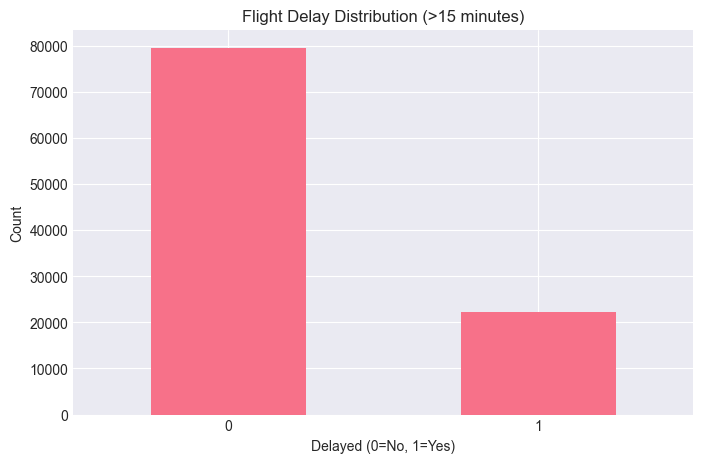

In [5]:
# Create a copy for preprocessing
df_model = df.copy()

# Create target variable: 1 if delayed (ARRIVAL_DELAY > 15 minutes), 0 otherwise
# 15 minutes is a common threshold for considering a flight as delayed
df_model['IS_DELAYED'] = (df_model['ARRIVAL_DELAY'] > 15).astype(int)

# Remove cancelled and diverted flights for delay prediction
df_model = df_model[(df_model['CANCELLED'] == 0) & (df_model['DIVERTED'] == 0)]

# Check class distribution
print("Class Distribution:")
print(df_model['IS_DELAYED'].value_counts())
print(f"\nDelay Rate: {df_model['IS_DELAYED'].mean()*100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(8, 5))
df_model['IS_DELAYED'].value_counts().plot(kind='bar')
plt.title('Flight Delay Distribution (>15 minutes)')
plt.xlabel('Delayed (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [6]:
# Feature Engineering
# Extract time-based features from DATE and SCHEDULED_DEPARTURE

# Convert DATE to datetime
df_model['DATE'] = pd.to_datetime(df_model['DATE'])

# Extract date features
df_model['MONTH'] = df_model['DATE'].dt.month
df_model['DAY_OF_WEEK'] = df_model['DATE'].dt.dayofweek  # 0=Monday, 6=Sunday
df_model['DAY_OF_MONTH'] = df_model['DATE'].dt.day

# Extract hour from SCHEDULED_DEPARTURE (format: HHMM as integer)
df_model['HOUR'] = (df_model['SCHEDULED_DEPARTURE'] // 100).astype(int)

# Create time of day categories
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_model['TIME_OF_DAY'] = df_model['HOUR'].apply(categorize_time)

# Is weekend?
df_model['IS_WEEKEND'] = (df_model['DAY_OF_WEEK'] >= 5).astype(int)

print("New features created:")
print(df_model[['DATE', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_OF_DAY', 'IS_WEEKEND']].head(10))

New features created:
         DATE  MONTH  DAY_OF_WEEK  HOUR TIME_OF_DAY  IS_WEEKEND
0  2015-01-01      1            3     5     Morning           0
1  2015-01-01      1            3     6     Morning           0
3  2015-01-01      1            3     6     Morning           0
4  2015-01-01      1            3     6     Morning           0
5  2015-01-01      1            3     6     Morning           0
6  2015-01-01      1            3     6     Morning           0
7  2015-01-01      1            3     6     Morning           0
8  2015-01-01      1            3     6     Morning           0
9  2015-01-01      1            3     6     Morning           0
10 2015-01-01      1            3     6     Morning           0


In [7]:
# Select relevant features for modeling
feature_columns = [
    'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE',
    'MONTH', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'HOUR', 
    'TIME_OF_DAY', 'IS_WEEKEND'
]

# Remove rows with missing values in key features
df_clean = df_model[feature_columns + ['IS_DELAYED']].dropna()

print(f"Records after cleaning: {len(df_clean):,}")
print(f"Features selected: {len(feature_columns)}")
print(f"\nMissing values:")
print(df_clean.isnull().sum())

Records after cleaning: 101,833
Features selected: 12

Missing values:
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
SCHEDULED_TIME         0
DISTANCE               0
MONTH                  0
DAY_OF_WEEK            0
DAY_OF_MONTH           0
HOUR                   0
TIME_OF_DAY            0
IS_WEEKEND             0
IS_DELAYED             0
dtype: int64


## 3. Exploratory Data Analysis

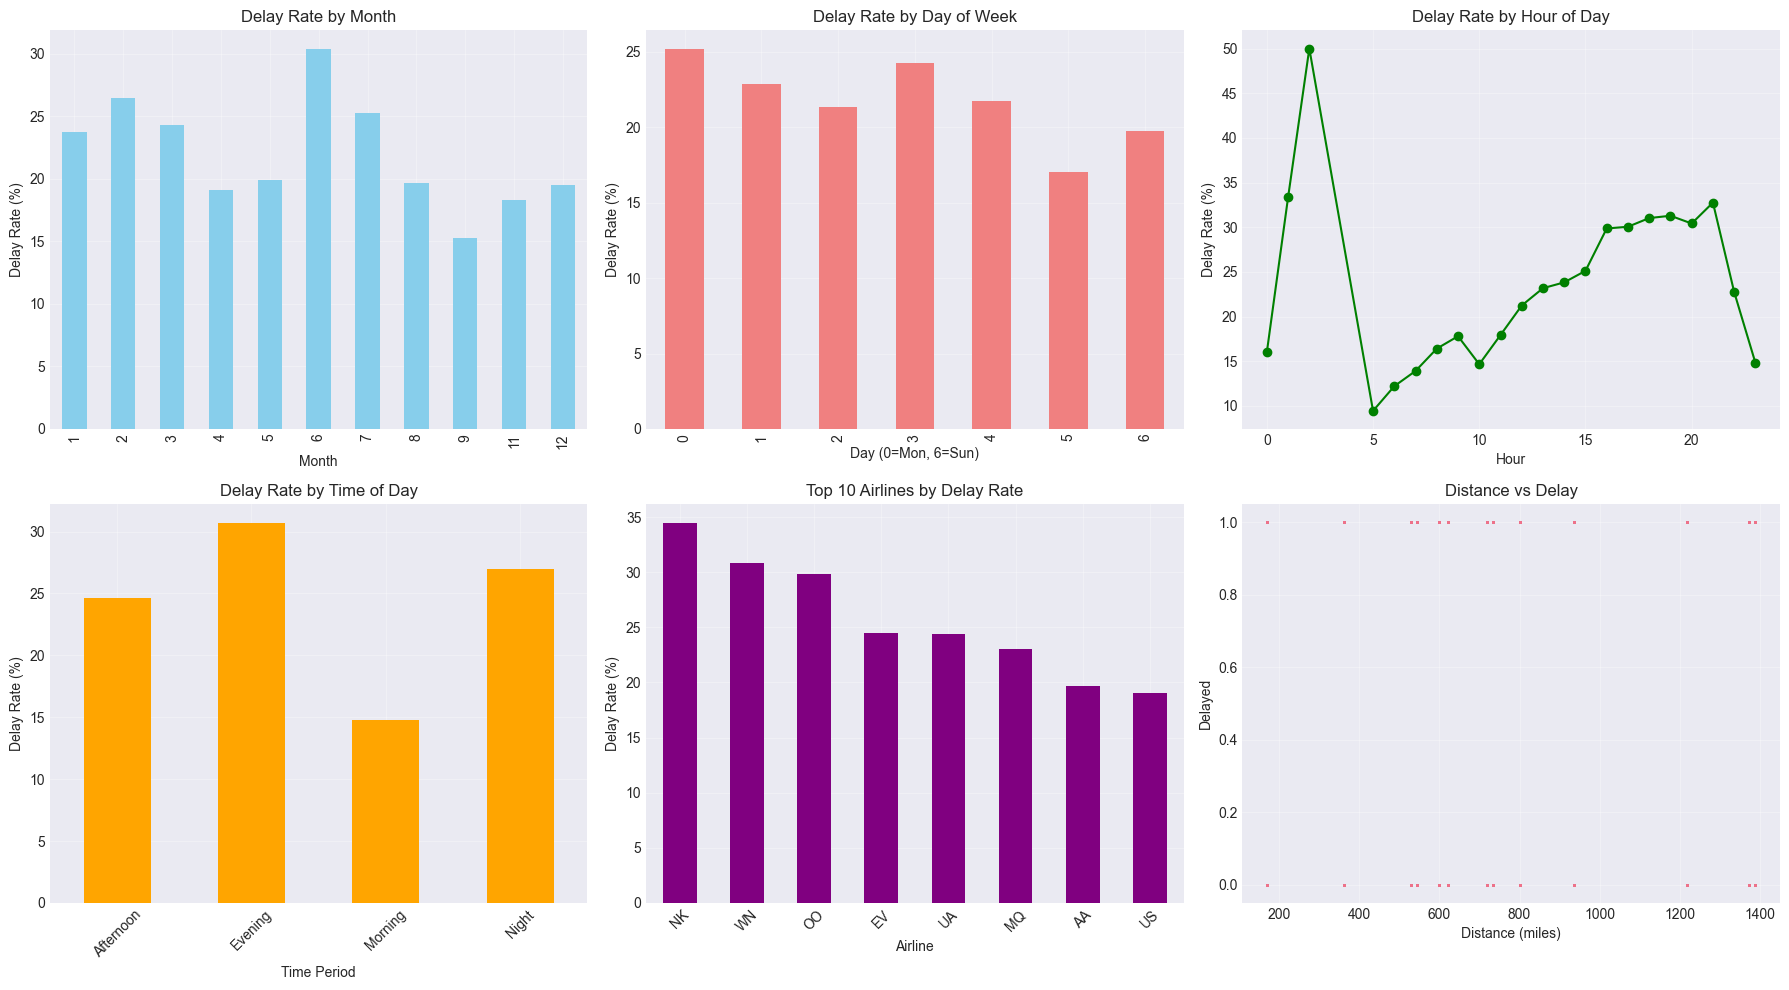

In [8]:
# Analyze delay patterns by different factors
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Delay by month
delay_by_month = df_clean.groupby('MONTH')['IS_DELAYED'].mean() * 100
delay_by_month.plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Delay Rate by Month')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Delay Rate (%)')
axes[0, 0].grid(True, alpha=0.3)

# Delay by day of week
delay_by_dow = df_clean.groupby('DAY_OF_WEEK')['IS_DELAYED'].mean() * 100
delay_by_dow.plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Delay Rate by Day of Week')
axes[0, 1].set_xlabel('Day (0=Mon, 6=Sun)')
axes[0, 1].set_ylabel('Delay Rate (%)')
axes[0, 1].grid(True, alpha=0.3)

# Delay by hour
delay_by_hour = df_clean.groupby('HOUR')['IS_DELAYED'].mean() * 100
delay_by_hour.plot(kind='line', ax=axes[0, 2], color='green', marker='o')
axes[0, 2].set_title('Delay Rate by Hour of Day')
axes[0, 2].set_xlabel('Hour')
axes[0, 2].set_ylabel('Delay Rate (%)')
axes[0, 2].grid(True, alpha=0.3)

# Delay by time of day
delay_by_tod = df_clean.groupby('TIME_OF_DAY')['IS_DELAYED'].mean() * 100
delay_by_tod.plot(kind='bar', ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Delay Rate by Time of Day')
axes[1, 0].set_xlabel('Time Period')
axes[1, 0].set_ylabel('Delay Rate (%)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Top 10 airlines by delay rate
airline_delays = df_clean.groupby('AIRLINE')['IS_DELAYED'].agg(['mean', 'count'])
airline_delays = airline_delays[airline_delays['count'] >= 100]  # At least 100 flights
airline_delays = airline_delays.sort_values('mean', ascending=False).head(10)
(airline_delays['mean'] * 100).plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Top 10 Airlines by Delay Rate')
axes[1, 1].set_xlabel('Airline')
axes[1, 1].set_ylabel('Delay Rate (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Distance vs Delay
axes[1, 2].scatter(df_clean['DISTANCE'], df_clean['IS_DELAYED'], alpha=0.1, s=1)
axes[1, 2].set_title('Distance vs Delay')
axes[1, 2].set_xlabel('Distance (miles)')
axes[1, 2].set_ylabel('Delayed')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Prepare Data for Machine Learning

In [9]:
# Encode categorical variables
df_encoded = df_clean.copy()

# Label encode categorical features
label_encoders = {}
categorical_features = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'TIME_OF_DAY']

for feature in categorical_features:
    le = LabelEncoder()
    df_encoded[feature] = le.fit_transform(df_encoded[feature].astype(str))
    label_encoders[feature] = le
    print(f"{feature}: {len(le.classes_)} unique values")

print("\nEncoded data sample:")
df_encoded.head()

AIRLINE: 9 unique values
ORIGIN_AIRPORT: 6 unique values
DESTINATION_AIRPORT: 6 unique values
TIME_OF_DAY: 4 unique values

Encoded data sample:


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,MONTH,DAY_OF_WEEK,DAY_OF_MONTH,HOUR,TIME_OF_DAY,IS_WEEKEND,IS_DELAYED
0,4,5,4,556,124.0,733,1,3,1,5,2,0,1
1,0,2,4,600,190.0,1389,1,3,1,6,2,0,0
3,2,1,5,600,123.0,599,1,3,1,6,2,0,1
4,7,3,1,610,121.0,529,1,3,1,6,2,0,0
5,4,2,5,616,139.0,802,1,3,1,6,2,0,0


In [10]:
# Split features and target
X = df_encoded.drop('IS_DELAYED', axis=1)
y = df_encoded['IS_DELAYED']

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set: 81,466 samples
Test set: 20,367 samples

Training set class distribution:
IS_DELAYED
0    63592
1    17874
Name: count, dtype: int64

Test set class distribution:
IS_DELAYED
0    15898
1     4469
Name: count, dtype: int64


In [11]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'DAY_OF_MONTH', 'HOUR']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("Features scaled successfully!")
print(f"\nFeature names: {X_train_scaled.columns.tolist()}")

Features scaled successfully!

Feature names: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'MONTH', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'HOUR', 'TIME_OF_DAY', 'IS_WEEKEND']


## 5. Build and Train Random Forest Model

In [ ]:
# Train Random Forest model
print("Training Random Forest model...")
print('='*60)

# Create and train the model
model = RandomForestClassifier(
    n_estimators=100,      # Số lượng cây quyết định
    max_depth=10,          # Độ sâu tối đa của cây
    random_state=42,
    n_jobs=-1              # Sử dụng tất cả CPU cores
)

model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✓ Model trained successfully!")
print(f"Accuracy: {accuracy:.2%}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['On-time', 'Delayed']))


Training Logistic Regression...

Accuracy: 0.7806
ROC-AUC Score: 0.6370

Classification Report:
              precision    recall  f1-score   support

     On-time       0.78      1.00      0.88     15898
     Delayed       0.00      0.00      0.00      4469

    accuracy                           0.78     20367
   macro avg       0.39      0.50      0.44     20367
weighted avg       0.61      0.78      0.68     20367


Training Random Forest...

Accuracy: 0.7834
ROC-AUC Score: 0.7156

Classification Report:
              precision    recall  f1-score   support

     On-time       0.78      1.00      0.88     15898
     Delayed       0.71      0.02      0.04      4469

    accuracy                           0.78     20367
   macro avg       0.74      0.51      0.46     20367
weighted avg       0.77      0.78      0.69     20367


Training Gradient Boosting...

Accuracy: 0.7960
ROC-AUC Score: 0.7402

Classification Report:
              precision    recall  f1-score   support

     On-

## 6. Model Evaluation

In [ ]:
# Confusion Matrix
print("Confusion Matrix:")
print("="*50)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Flight Delay Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['On-time', 'Delayed'])
plt.yticks([0.5, 1.5], ['On-time', 'Delayed'])
plt.show()

print(f"\nTrue Negatives (On-time predicted correctly): {cm[0,0]}")
print(f"False Positives (On-time predicted as Delayed): {cm[0,1]}")
print(f"False Negatives (Delayed predicted as On-time): {cm[1,0]}")
print(f"True Positives (Delayed predicted correctly): {cm[1,1]}")

## 7. Feature Importance Analysis

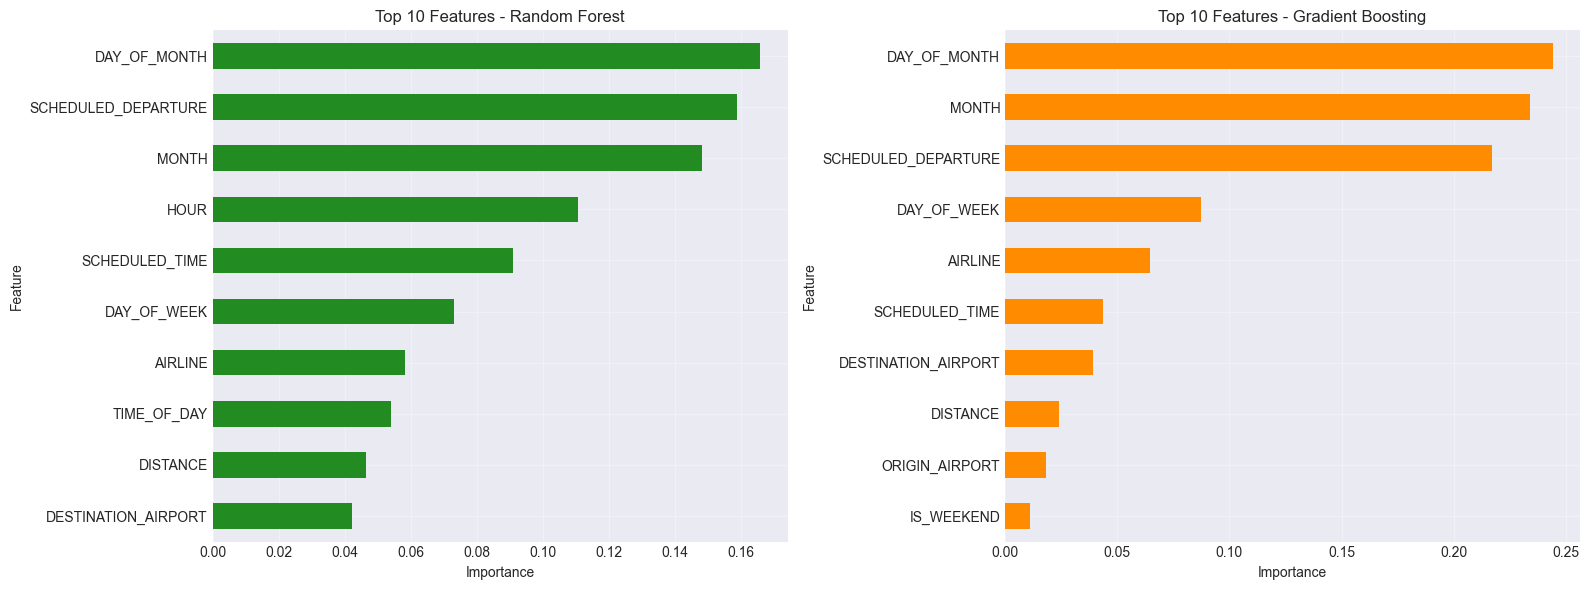


Top 10 Most Important Features (Random Forest):
            Feature  Importance
       DAY_OF_MONTH    0.165887
SCHEDULED_DEPARTURE    0.159029
              MONTH    0.148416
               HOUR    0.110626
     SCHEDULED_TIME    0.091087
        DAY_OF_WEEK    0.073247
            AIRLINE    0.058168
        TIME_OF_DAY    0.054006
           DISTANCE    0.046511
DESTINATION_AIRPORT    0.042212


In [16]:
# Feature importance - Những yếu tố nào ảnh hưởng đến delay?
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print("="*60)
print(feature_importance.head(10).to_string(index=False))
print("="*60)

# Visualize
plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(
    x='Feature', 
    y='Importance', 
    kind='barh', 
    legend=False, 
    color='forestgreen'
)
plt.title('Top 10 Most Important Features for Flight Delay Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Prediction Examples

In [17]:
# Test predictions with sample data
print("Sample Flight Delay Predictions:")
print("="*80)

# Get 10 random samples
sample_indices = np.random.choice(X_test_scaled.index, 10, replace=False)
sample_data = X_test_scaled.loc[sample_indices]
sample_actual = y_test.loc[sample_indices]

# Make predictions
sample_predictions = model.predict(sample_data)
sample_probabilities = model.predict_proba(sample_data)[:, 1]

# Display results
prediction_results = pd.DataFrame({
    'Actual': ['Delayed' if x == 1 else 'On-time' for x in sample_actual],
    'Predicted': ['Delayed' if x == 1 else 'On-time' for x in sample_predictions],
    'Delay Probability': [f"{p:.1%}" for p in sample_probabilities],
    'Correct': ['✓' if a == p else '✗' for a, p in zip(sample_actual, sample_predictions)]
})

print(prediction_results.to_string(index=False))
print("="*80)

# Calculate correct predictions
correct = (sample_actual.values == sample_predictions).sum()
print(f"\nCorrect predictions: {correct}/{len(sample_predictions)}")

Best Model: Gradient Boosting
ROC-AUC Score: 0.7402
Accuracy: 0.7960

Sample Predictions:
 Actual Predicted Delay Probability  Correct
On-time   On-time            39.64%     True
On-time   On-time            17.13%     True
On-time   On-time            17.02%     True
On-time   On-time            38.82%     True
On-time   On-time            14.41%     True
On-time   On-time            15.51%     True
Delayed   On-time            30.99%    False
On-time   On-time            14.48%     True
Delayed   Delayed            50.14%     True
On-time   On-time            10.78%     True


## 9. Summary

### Kết quả:

**Mô hình Random Forest** được sử dụng để dự đoán chuyến bay bị delay.

**Các yếu tố quan trọng ảnh hưởng đến delay:**
1. **Thời gian bay**: Giờ khởi hành, buổi trong ngày, ngày trong tuần
2. **Tuyến bay**: Sân bay đi và sân bay đến
3. **Hãng hàng không**: Mỗi hãng có tỷ lệ delay khác nhau
4. **Khoảng cách**: Quãng đường bay ảnh hưởng đến khả năng delay
5. **Thời gian dự kiến**: Thời gian bay theo kế hoạch

**Ứng dụng thực tế:**
- Dự đoán chuyến bay có thể bị delay trước khi cất cánh
- Giúp hành khách lên kế hoạch tốt hơn
- Hãng hàng không có thể tối ưu hóa lịch bay
- Cải thiện quản lý nguồn lực

**Cách sử dụng:**
- Nhập thông tin chuyến bay (hãng, tuyến, giờ bay)
- Mô hình trả về xác suất delay (0-100%)
- Nếu xác suất > 50%: Chuyến bay có khả năng bị delay